# Binary Neural Networks Demo
##### In this project, we develop a binary neural network for MNIST digit classification. Binary neural networks only use -1s or 1s. The main goal of this project is to implement a neural network using XNOR and popcount operators instead of multiplication and summation.

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from tqdm import tqdm

## Load Data
##### Make sure to add bnn_project.zip to google colab

In [ ]:
path_to_bnn_zip = "/content/bnn_project.zip"
with zipfile.ZipFile(path_to_bnn_zip, 'r') as zip_ref:
    zip_ref.extractall("/content")



The shape of the input: (10000, 28, 28)
The shape of the labels: (10000,)



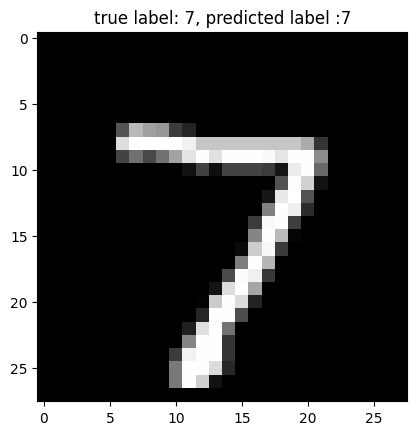


The shape of the input reshaped: (10000, 784)


In [ ]:
def visualize(data, true_label, predicated_label):
    """This function prints image, true label and predicted label.

    :param data:
    :param true_label:
    :param predicated_label:
    :return:
    """

    plt.imshow(data, cmap='gray')
    # Display the image at index 0 from the train_data dataset using imshow()
    # The cmap='gray' argument specifies that the image should be displayed in grayscale

    plt.title("true label: {}, predicted label :{}".format(true_label, predicated_label))
    # Set the title of the plot to the label/target corresponding to the image at index 0
    # The '%i' is a placeholder that will be replaced by the value of train_data.targets[0]

    plt.show()
    # Display the plot


# Load the data and visualize

mnist = np.load("/content/bnn_project/python/dataset/mnist_test_data_original.npy", allow_pickle=True)
X = mnist.item().get("data")
y = mnist.item().get("label")
print("The shape of the input: {}".format(X.shape))
print("The shape of the labels: {}".format(y.shape))
print()
visualize(X[0], y[0], y[0])


X = np.reshape(X, (10000, 784))
print()
print("The shape of the input reshaped: {}".format(X.shape))

## Normal vs XNOR vector multiplication

In [ ]:
""" This is a toy example that demonstrates how to
multiply two binary vectors using XNOR and popcount
"""

# XNOR operation
XNOR = lambda x, y: 1 if x == y else 0

# Sign function
sign = lambda x: float(1) if x>0 else float(-1)
sign = np.vectorize(sign)

# Convert -1,1 to 0,1 binary for XNOR operation
quantize = lambda x: float(0) if x == 1 else float(1)
quantize = np.vectorize(quantize)


# Example vectors
a = np.array([10, -10, -5, 9, -8, 2, 3, 1, -11])
b = np.array([12, -18, -13, -13, -14, -15, 11, 12, 13])

# Convert to binary vectors using sign function
a = sign(a)
b = sign(b)

# Normal Matrix multi
matmul_result = np.matmul(a, b)

# XNOR matmul
a = quantize(a)
b = quantize(b)

xnormatmul_sum = 0
for x in range(len(a)):
    # Doing XNOR and popcount
    xnormatmul_sum = xnormatmul_sum + XNOR(a[x], b[x])



# Convince yourself why this next operation is necessary:
# In the final XNOR result, say P is the number of 1's (xnormatmul_sum in this case)  and N is the number of 0's
# Then in terms of P and N, result = P - N
# Notice what we are doing here:
# 2*P - len(a) = 2*P - (P+N) = P - N
# Which is what we were looking for.
xnor_result = 2*xnormatmul_sum-len(a)

print("Matmul result: {}, XNOR result: {}".
      format(matmul_result, xnor_result))



Matmul result: 3.0, XNOR result: 3


## Demo Walkthrough of BNN
### Here is a demo walkthrough of the forward pass of a BNN. We use dummy weights and data inputs

In [ ]:
# Dummy Data
X = np.array([1, 1])

w1 = np.array([[1, 1],
               [1, 1]])

w2 = np.array([[1, 0, 1],
               [1, 1, 0]])
# w3 = np.array([[1, 0, 1],
#                [0, 1]])

In [ ]:
# Defining operation functions

def XNOR(a, b):
    return 1 if a == b else 0

def matmul_xnor(A, B):
    a, b = B.shape
    res = np.zeros(b)

    A1 = A.astype(int)
    B1 = B.astype(int)

    for x in range(b):
        cnt = 0
        for y in range(a):
            cnt = cnt + XNOR(A1[y], B1[y][x])

        res[x] = cnt
    return res

def quantize(x):
  return float(0) if x == 1 else float(1)

def sign(x):
  return float(1) if x > 0 else float(-1)

def adj(x):
  return x * 2 - 1

In [ ]:
# Forward pass
# Notice that we do not vectorize any of the operations, rather we use full for loops.
# Later in this notebook you will notice that we vectorize these operations.

def feed_forward_quantized(X, w1, w2):

    # Layer 1
    X0_input = np.zeros(X.shape)
    for i in range(X.shape[0]):
        X0_input[i] = quantize(sign(adj(X[i])))

    layer1_output = matmul_xnor(X0_input, w1)
    layer1_activations = (layer1_output * 2 - X0_input.shape[0])

    # Layer 2
    layer2_quantized = np.zeros(layer1_activations.shape)
    for i in range(layer1_activations.shape[0]):
        layer2_quantized[i] = quantize(sign(layer1_activations[i]))
    layer2_output = matmul_xnor(layer2_quantized, w2)
    final_output = (layer2_output * 2 - layer1_activations.shape[0])
    A = np.array([final_output], np.int32)
    return A

print(feed_forward_quantized(X, w1, w2))

[[2 0 0]]


## BNN Model Class
#### Next we will make predictions on the actual MNIST dataset.

In [ ]:

class BNN_MNIST:

    def __init__(self, model_path, batch_size=64):
        self.batch_size = batch_size

        # Sign function for converting to +/- 1
        self.sign = lambda x: float(1) if x>0 else float(-1)
        self.sign = np.vectorize(self.sign)

        # Quantize function for representing +/- 1 as 0 or 1.
        self.quantize = lambda x: float(0) if x == 1 else float(1)
        self.quantize = np.vectorize(self.quantize)

        # Adjust input pixel intensities
        self.adj = lambda x: x*2-1
        self.adj = np.vectorize(self.adj)

        # Load model
        self.model = np.load(model_path, allow_pickle=True).item()

        # Layer 1 weights (128, 784)
        self.fc1w_q = self.sign(np.array(self.model['fc1w']))
        # Layer 2 weights (64, 128)
        self.fc2w_q = self.sign(np.array(self.model['fc2w']))
        # Layer3 weights (64, 10)
        self.fc3w_q = self.sign(np.array(self.model['fc3w']))

        # Quantisized weights (1s and 0s)
        self.fc1w_qntz = self.quantize(self.fc1w_q)
        self.fc2w_qntz = self.quantize(self.fc2w_q)
        self.fc3w_qntz = self.quantize(self.fc3w_q)

    def feed_forward(self, input):
        """This BNN using normal MAC.

        :return:
        """
        X0_q = self.sign(self.adj(input))

        X1 = np.matmul(X0_q, self.fc1w_q.T)

        X1_q = self.sign(X1)

        X2 = np.matmul(X1_q, self.fc2w_q.T)

        X2_q = self.sign(X2)

        X3 = np.matmul(X2_q, self.fc3w_q.T)

        return X3

    def feed_forward_quantized(self, input):
        """This function does BNN. Uses XNOR. Note this function only works for batch size 1.

        :param input: MNIST sample input
        :return:
        """
        # layer 1
        X0_input = self.quantize(self.sign(self.adj(input)))[0]
        layer1_output = self.matmul_xnor(X0_input, self.fc1w_qntz.T)
        # Popcount for each activation. Look back to "Normal vs XNOR vector multiplication"
        # to see why this is necessary
        layer1_activations = (layer1_output * 2 - 784)


        # layer 2
        layer2_input = self.sign(layer1_activations)
        layer2_quantized = self.quantize(layer2_input)
        layer2_output = self.matmul_xnor(layer2_quantized, self.fc2w_qntz.T)
        layer2_activations = (layer2_output * 2 - 128)


        # layer 3
        layer3_input = self.sign(layer2_activations)
        layer3_quantized = self.quantize(layer3_input)
        layer3_output = self.matmul_xnor(layer3_quantized, self.fc3w_qntz.T)

        final_output = (layer3_output * 2 - 64)
        A = np.array([final_output], np.int32)

        return A

    def XNOR(self, a, b):
        if (a == b):
            return 1
        else:
            return 0

    def matmul_xnor(self, A, B):
        """This function calculates matrix multiplication between two vectors using XNOR.
        Currently only functional for batch size of 1.

        :param A: The first quantized vector
        :param B: The second quantized  vector
        :return:
        """

        a, b = B.shape

        res = np.zeros(b)

        A1 = A.astype(int)
        B1 = B.astype(int)

        for x in range(b):
            cnt = 0
            for y in range(a):
              cnt = cnt + self.XNOR(A1[y], B1[y][x])

            res[x] = cnt
        return res


    def pack(self, A, n):
        """Helper function for converting numpy array of bits to 32 bit integer array.
        :param A: numpy array
        :param n: A.shape[0]*A.shape[1] i.e. total number of bits in array.
        :return:

        """
        A_bit = np.array([0] * (n // 32), dtype=np.uint32)

        A_lin = np.reshape(A, (n,))

        # convert every 32 bit sequence into a single integer number.
        for i in range(0, n, 32):
            A_bit[i // 32] = self.concat4(A_lin, i)

        return A_bit


    def quantize_scale(self, x):
        """Helper function for converting +/- 1 to 1s and 0s
        :param x:
        :return:
        """

        if x == -1:
            return 1
        elif x == 1:
            return 0

    def concat4(self, li, point):
        """Helper function for converting the bits li[point: point+32] to a single interger.
        :param li: Array
        :param point: integer index into the array
        :return:
        """

        result = np.array([self.quantize_scale(li[point])], dtype=np.uint32)[0].astype(np.uint32)


        for k in range(1, 32):
            i = point + k
            result <<= 1
            result &= 0xFFFFFFFF
            result |= self.quantize_scale(li[i])
            result &= 0xFFFFFFFF
        return result.astype(np.uint32)

    def preprocessModel(self, dataset_folder_path, X, y):
        """Helper function to convert input data, X, to 32 bit integers and save them along with the labels y.
        :param X:
        :param y:
        :return:
        """
        sample = 2
        numpydict = {"X": [], "y": []}

        #  X is shape (N x 784)
        # Pad each sample with 16 1s so that X is (N x 800)
        # We do this because when converting the bit array to integers, we need
        # the array size to be a multiple of 32. 800 is a multiple of 32 however, 784 is not.
        # Therefore we pad.
        X0_q = np.array([list(arr) + [1] * 16 for arr in X])

        # See documentation for function pack()
        X0_bit = self.pack(X0_q, X0_q.shape[0] * X0_q.shape[1])
        Y0 = y
        numpydict["X"].append(X0_bit)
        numpydict["y"].append(Y0)

        np.save(f'{dataset_folder_path}/mnist-bit_sample{sample}.npy', numpydict, allow_pickle=True)


    def create_input(self, data_path, dataset_folder_path, num_of_samples):
        """This function creates packed inputs for a given number of samples.
        The created inputs are used for HLS tesbench. "Packed" means to convert
        the input array into 32 bit integer numbers.

        :param num_of_samples:
        :return:
        """

        mnist = np.load(data_path, allow_pickle=True)
        X = mnist.item().get("data")
        y = mnist.item().get("label")

        X = np.reshape(X, (10000, 784))

        if num_of_samples == 0:
            num_of_samples = (len(X) // self.batch_size)

        numpydict = {"X": [], "y": []}

        for idx in range(num_of_samples):
            # Get batch
            xs = X[self.batch_size * idx:self.batch_size * idx + self.batch_size]
            ys = y[self.batch_size * idx:self.batch_size * idx + self.batch_size]

            X0_q = self.sign(self.adj(xs))
            self.preprocessModel(dataset_folder_path, X0_q, ys)

            #  X is shape (N x 784)
            # Pad each sample with 16 1s so that X is (N x 800)
            # We do this because when converting the bit array to integers, we need
            # the array size to be a multiple of 32. 800 is a multiple of 32 however, 784 is not.
            # Therefore we pad.
            X0_q = np.array([list(arr) + [1] * 16 for arr in X0_q])

            # See function pack()
            X0_bit = self.pack(X0_q, X0_q.shape[0] * X0_q.shape[1])
            Y0 = ys
            numpydict["X"].append(X0_bit)
            numpydict["y"].append(Y0)

        np.save(f'{dataset_folder_path}/mnist-bit_sample{num_of_samples}.npy', numpydict, allow_pickle=True)



    def create_packed_weights(self, weights_folder_path):
        """Helper function: This function creates packed weights for HLS.
        "Packed" means to convert the weights arrays into 32 bit integer numbers.

        :return:
        """

        # fc1w_q is shape (128 x 784)
        # Pad each row with 16 1s so that fc1w_q is (128 x 800)
        # We do this because when converting the bit array to integers, we need
        # the array size to be a multiple of 32. 800 is a multiple of 32 however, 784 is not.
        # Therefore we pad.
        fc1w_q = np.array([list(arr) + ([1] * 16) for arr in self.fc1w_q])
        # See function pack()
        fc1w_bit = self.pack(fc1w_q.T.T, fc1w_q.shape[0] * fc1w_q.shape[1])
        fc1w_bit = self.pack(fc1w_q, fc1w_q.shape[0] * fc1w_q.shape[1])

        fc2w_q = self.fc2w_q
        fc2w_bit = self.pack(fc2w_q, fc2w_q.shape[0] * fc2w_q.shape[1])

        fc3w_q = self.fc3w_q
        fc3w_bit = self.pack(fc3w_q, fc3w_q.shape[0] * fc3w_q.shape[1])

        np.savetxt(f'{weights_folder_path}/layer1.txt', fc1w_bit)
        np.savetxt(f'{weights_folder_path}/layer2.txt', fc2w_bit)
        np.savetxt(f'{weights_folder_path}/layer3.txt', fc3w_bit)


        return fc1w_bit, fc2w_bit, fc3w_bit


    def write_to_file(self, weights_folder_path, w1, w2, w3):
        """ Helper function
        :param w1:
        :param w2:
        :param w3:
        :return:
        """
        # Writing to file
        with open(f"{weights_folder_path}/layer1_c.txt", "w") as file1:
            # Writing data to a file
            for x in range(len(w1)):
                file1.writelines(str(w1[x])+",")

        with open(f"{weights_folder_path}/layer2_c.txt", "w") as file1:
            # Writing data to a file
            for x in range(len(w2)):
                file1.writelines(str(w2[x])+",")

        with open(f"{weights_folder_path}/layer3_c.txt", "w") as file1:
            # Writing data to a file
            for x in range(len(w3)):
                file1.writelines(str(w3[x])+",")

    def hlscode(self):
        """This is a reference implementation for HLS.
        Intentionally, left empty so that students implement the HLS ref design.

        :return:
        """

        print("Done")


    def visualize(self, data, true_label, predicated_label):
        """This function prints image, true label and predicted label.

        :param data:
        :param true_label:
        :param predicated_label:
        :return:
        """
        # Visualization
        import matplotlib.pyplot as plt

        # Import the matplotlib.pyplot module for visualization purposes

        plt.imshow(data, cmap='gray')
        # Display the image at index 0 from the train_data dataset using imshow()
        # The cmap='gray' argument specifies that the image should be displayed in grayscale

        plt.title("true label: {}, predicted label :{}".format(true_label, predicated_label))
        # Set the title of the plot to the label/target corresponding to the image at index 0
        # The '%i' is a placeholder that will be replaced by the value of train_data.targets[0]

        plt.show()
        # Display the plot

    def run_test_visalize(self, data_path, num_samples):
        """This function is for debugging. Used for visualizing
        the input (MNIST image), the predicted output and the true output.
        :param data_path: path to the mnist dataset
        :param num_samples: number of samples to visualize
        :return:
        """


        mnist = np.load(data_path, allow_pickle=True)
        X = mnist.item().get("data")
        y = mnist.item().get("label")

        X = np.reshape(X, (10000, 784))
        print(X.shape)


        # Visulize input image prediction and true label for all samples
        for idx in range(num_samples):
            xs = X[idx]
            ys = y[idx]
            outputs = self.feed_forward(xs)
            xs_plot = np.reshape(xs, (28, 28))
            self.visualize(xs_plot, ys, np.argmax(outputs))

    def run_test(self, X, y, use_normal_mac=False):
        """This function is for testing

        :param use_normal_mac: Setting this parameter calls self.feed_forward (uses MAC),
        otherwise, it calls feed_forward_quantized which uses XNOR

        :return:
        """

        prediction = []

        i = 0

        # set inference function
        if use_normal_mac is True:
            inference_function = self.feed_forward
        else:
            inference_function = self.feed_forward_quantized


        for idx in tqdm(range(len(X) // self.batch_size)):
            # Get Batch
            xs = X[self.batch_size * idx:self.batch_size * idx + self.batch_size]
            ys = y[self.batch_size * idx:self.batch_size * idx + self.batch_size]

            # Inference
            outputs = inference_function(xs)

            # Prediction correct or not
            for output, yk in zip(outputs, ys):
                prediction.append(np.argmax(output) == (yk))
            i += 1


        # calculate score
        score = np.mean(prediction) * 100

        return score



## Inference on MNIST


In [ ]:
# Make sure data is loaded
print("The shape of the input: {}".format(X.shape))
print("The shape of the output: {}".format(y.shape))

The shape of the input: (2,)
The shape of the output: (10000,)


In [ ]:
# Create Model Instance
# Note that the XNOR matrix multiplication implimentation only works with batch_size 1 currently.
bnn = BNN_MNIST(model_path="/content/bnn_project/python/weights/model.npy", batch_size=1)

In [ ]:
# Run Model Using normal matrix multiplication
print("Running BNN which uses MAC")
print("\nAccuracy:", bnn.run_test(X, y, use_normal_mac=True))

Running BNN which uses MAC


100%|██████████| 10000/10000 [00:24<00:00, 409.40it/s]


Accuracy: 89.39


In [ ]:
# Run Model using XNOR for matrix multiplication
# Note that this may take up to 15 minutes
print("Running BNN which uses XNOR")
print("Accuracy:", bnn.run_test(X[:10], y, use_normal_mac=False))


Running BNN which uses XNOR


100%|██████████| 10/10 [00:00<00:00, 12.60it/s]

Accuracy: 90.0


## TODO In the BNN class, the function hls() is for you to complete

In [ ]:
bnn.hlscode()

Done
